# Set up environments

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [3]:
# !pip install transformers

In [4]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('../data')

In [5]:
from _arfima import arfima
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer, BertModel, AutoTokenizer, BertForQuestionAnswering,BertForSequenceClassification

# Generate 1d time-series data

In [6]:
# create the time series dataset
size = 10000
np.random.seed(505)
### arfima(ar,d,ma)
### ar and ma term are list-like, d is a number.
long_range_stationary_x_vals = arfima([0.5,0.4],0.3,[0.2,0.1],size,warmup=2^10)

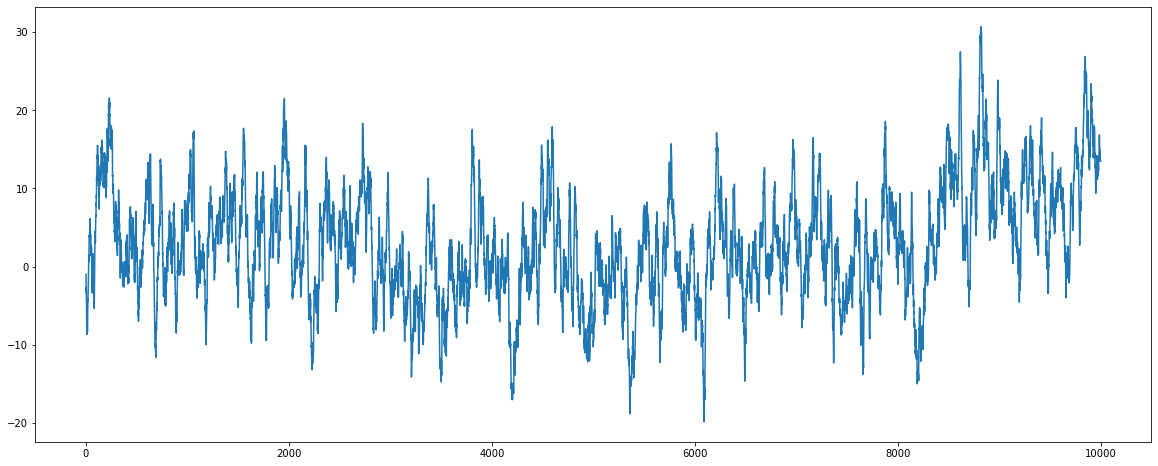

In [7]:
# take a look at the time-series data
plt.figure(figsize=(20,8))
plt.plot(long_range_stationary_x_vals)

# Preprocessings

In [8]:
# treat time series like seq2seq pairs
# nlp model can only fit in integer for the embedding
time, value = range(size),[round(long_range_stationary_x_vals[i],3)*1000 for i in range(size)]

In [9]:
dic = [{'input_ids':torch.IntTensor([time[i], value[i]]),
                'token_type_ids':torch.IntTensor([0,1]) ,
                'attention_mask': torch.IntTensor([1,1])} for i in range(size)]

<ipython-input-9-001d06590bcc>:1: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dic = [{'input_ids':torch.IntTensor([time[i], value[i]]),


In [17]:
class DataSet(Dataset):
    def __init__(self, dic):
        self.dic = dic

    def __len__(self):
        return len(self.dic)

    def __getitem__(self, idx):
        return self.dic[idx]

In [18]:
train_data = DataSet(dic)

In [19]:
# each training wiil look like a dictionary
train_data[0]

{'input_ids': tensor([   0, -991], dtype=torch.int32),
 'token_type_ids': tensor([0, 1], dtype=torch.int32),
 'attention_mask': tensor([1, 1], dtype=torch.int32)}

# Model training

Here I used the bare BERT model(without any specific head) since I feel like the time series task cannot match with any NLP tasks, so using the BERT pretrained on a specific task makes no sense.

In [15]:
model = BertModel.from_pretrained('bert-base-uncased') # the bare bert model with only the model configuration loaded from the well-trained models
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = Trainer(model=model, train_dataset=train_data)
trainer.train()

# Summrization of the failure

1. Fatal reason: The nlp model fails to run since the input of the model should be torch.dataset, which requires 'labels' as one of the argument. However, in time series data, we don't have 'labels' and it makes no sense to create label or to treat the value(y-axis) as the label. 

2. nlp models requires the embedding array to be integer, but for time series, the value is float. One possible solution is to round the value to integer, but that would seriously degrade the representation of the model.

3. Transformer based nlp models are built for seq2seq tasks(e.g.machine translation, Q&A). However, if we treat the time-series to be in a seq2seq pattern(i.e. each time point pairs with its corresponing value), then it will be like word-to-word since the embedding size is only 1d. While in the mainstream nlp tasks, the sequence unit should be a sentence or even a document.

4. It is hard to match the time series task with any of the nlp tasks, so using the BERT(or other NLP model) pretrained on a specific NLP task makes no sense.

5. Due to the attention mechnism, the transformer is usually good at predicting on repeated values, that's why it works so well in NLP(in nlp, the corpus is limited, and many words appears very often), but things are different in time-series.
